In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [28]:
df = pd.read_csv(r"Data/amazon_baby.csv", index_col = 0)
df = df.head(100)

In [29]:
import json
with open(r'Data\important_words.json', 'r') as f: # Reads the list of most frequent words
    important_words = json.load(f)
important_words = [str(s) for s in important_words]

In [30]:
df = df[df['rating'] != 3] # ensuring neutral rating are ignored
df = df.dropna()
df['sentiment'] = df['rating'].apply(lambda rating : +1 if rating >3 else 0)
df.head()

,name,review,rating,sentiment
1,Planetwise Wipe Pouch,it came early and was not disappointed. i love...,5.0,1
2,Annas Dream Full Quilt with 2 Shams,Very soft and comfortable and warmer than it l...,5.0,1
3,Stop Pacifier Sucking without tears with Thumb...,This is a product well worth the purchase. I ...,5.0,1
4,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5.0,1
5,Stop Pacifier Sucking without tears with Thumb...,"When the Binky Fairy came to our house, we did...",5.0,1


In [31]:
df['review_clean'] = df['review'].str.replace('[^\w\s]','')  # Remove punctutation
df['review_clean'] = df['review_clean'].str.replace('\d+', '') # Remvove numerics
df['bias'] = 1  # Add Bias : Important for gradient descent

In [32]:
for word in important_words: # Create word count matrix : input feature matrix
    df[word] = df['review_clean'].apply(lambda s: str(s).split().count(word))

In [33]:
df.head(2)

,name,review,rating,sentiment,review_clean,bias,baby,one,great,love,...,seems,picture,completely,wish,buying,babies,won,tub,almost,either
1,Planetwise Wipe Pouch,it came early and was not disappointed. i love...,5.0,1,it came early and was not disappointed i love ...,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,Annas Dream Full Quilt with 2 Shams,Very soft and comfortable and warmer than it l...,5.0,1,Very soft and comfortable and warmer than it l...,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
df['sentiment'].value_counts()

1    77
0    11
Name: sentiment, dtype: int64

In [35]:
# Input & Output Array
features = df.iloc[:,5:].values
output = df['sentiment'].values.reshape(-1, 1)

$$
P(y_i = +1 | \mathbf{x}_i,\mathbf{w}) = \frac{1}{1 + \exp(-\mathbf{w}^T h(\mathbf{x}_i))},
$$
$$ grad = \sum h(\mathbf{x}_i)[\mathbf{1}[y_i = +1] - \sigma^{w^T h(\mathbf{x}_i)}]$$
$$\ell\ell(\mathbf{w}) = \sum_{i=1}^N \Big( (\mathbf{1}[y_i = +1] - 1)\mathbf{w}^T h(\mathbf{x}_i) - \ln\left(1 + \exp(-\mathbf{w}^T h(\mathbf{x}_i))\right) \Big) $$


In [38]:
# Generate Functions
def get_predictions(features, coefficients):
    ''' Prediction is the sigmoid of WX '''
    pred = np.dot(features, coefficients)
    probability = 1/(1 + np.exp(-pred)).reshape(-1, 1)
    return probability

def get_gradient(error, features, coefficient, is_intercept, l2_penalty):
    ''' Gradient is product of error and features : Refer Notes '''
    grad = np.dot(features.T, error)
    if not is_intercept: 
        grad = grad - 2*l2_penalty*coefficient
    return grad

def get_log_likelihood(features, output, coefficients):
    ''' Log Likelihood is as per above formula '''
    indicator = (output == +1)
    pred = np.dot(features, coefficients)
    first_term = (indicator - 1)*pred
    second_term = np.log(1 + np.exp(-pred))
    log_ll = np.sum(first_term - second_term)
    return log_ll

In [49]:
def logistic_reg_run(features, output, l2_penalty):
    log_ll = []
    coefficients = np.zeros(shape = (194,1))
    for i in np.arange(100):
        prob = get_predictions(features, coefficients)
        out_indicator = (output == +1)
        error = out_indicator - prob
        for j in np.arange(len(coefficients)):
            is_intercept = (j == 0)
            grad = get_gradient(error, features[:,j], coefficients[j], is_intercept, l2_penalty)
            coefficients[j] = coefficients[j] + 0.05*grad
        log_ll.append(get_log_likelihood(features, output, coefficients))
        # if i % 10 == 0:
        #     print(log_ll[i])
    return coefficients, log_ll
    # Note likelihood is increasing over iterations

In [145]:
df_coeff = pd.DataFrame([df.iloc[:,5:].columns]).T
df_coeff.columns = ['words']
l2_penalty_list=[0, 4, 8, 10]
for l2_penalty in l2_penalty_list:
    coefficients, log_ll = logistic_reg_run(features, output, l2_penalty)
    df_coeff[l2_penalty] = coefficients
df_coeff.columns = df_coeff.columns.astype(str)
df_coeff

,words,0,4,8,10
0,bias,1.630303,1.813867,1.846826,1.858810
1,baby,0.902850,0.131574,0.085466,0.072844
2,one,-0.308452,-0.074266,-0.041804,-0.033865
3,great,2.147333,0.250021,0.145937,0.121033
4,love,1.571337,0.173036,0.099155,0.081786
...,...,...,...,...,...
189,babies,0.221210,0.033061,0.019439,0.016113
190,won,0.000000,0.000000,0.000000,0.000000
191,tub,0.000000,0.000000,0.000000,0.000000
192,almost,-1.084680,-0.096990,-0.051402,-0.041620


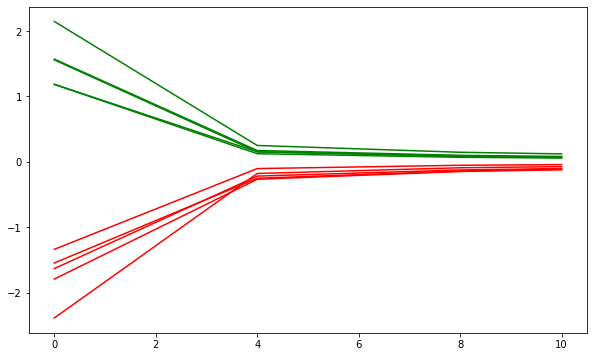

In [151]:
negative_words = list(df_coeff[1:].sort_values(by='0').head(5)['words'].values)
positive_words = list(df_coeff[1:].sort_values(by='0').tail(5)['words'].values)
top_words = negative_words + positive_words
df_coeff_top = df_coeff[df_coeff['words'].isin(top_words)].sort_values(by='0').reset_index(drop = True)
# df_coeff_top
for i in np.arange(df_coeff_top.shape[0]):
    if i <= 4:
        color = 'r'
    else:
        color = 'g'
    plt.plot(l2_penalty_list, df_coeff_top.iloc[i,1:].values, color = color)

In [148]:
df_coeff_top

,words,0,4,8,10
0,used,-2.389722,-0.178714,-0.091474,-0.073514
1,waste,-1.794192,-0.267445,-0.148765,-0.121508
2,got,-1.634211,-0.218631,-0.124739,-0.102446
3,money,-1.548277,-0.251638,-0.140801,-0.115144
4,received,-1.339584,-0.103763,-0.053326,-0.042881
5,keep,1.184278,0.123689,0.069033,0.056541
6,first,1.186225,0.152736,0.086930,0.071532
7,perfect,1.559713,0.152471,0.084177,0.068747
8,love,1.571337,0.173036,0.099155,0.081786
9,great,2.147333,0.250021,0.145937,0.121033


## Notes:
1. The coeff values were increasing with greater l2 penalty. Probably sensitive to this dataset. Best approach is to cross-val and choose ideal l2_penalty.         
2. The coeff values are nicely decreasing towards zero with inc l2_penalty.         
3. In contrast, the likelihood will be decreasing with l2_penalty.    
4. we do not apply the L2 penalty on the intercept. A large intercept does not necessarily indicate overfitting because the intercept is not associated with any particular feature.       